In [27]:
import os
IMAGES_PATH = "/home/luminoso/thesis/gjc-ml-2018abr/"
def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
labnames = {
    'np_freebsd.raw':'Lab-D',
    'np_nuc.raw':'Lab-A',
    'np_tohiba.raw':'Lab-C',
    'np_ubuntu.raw':'Lab-1',
    'np_windows10x86.raw':'Lab-2',
    'np_x58pc.raw':'Lab-B'
}


In [3]:
# Load serialized dataframe

import pickle
import pandas as pd

# [86400, 21600, 7200, 3600, 900]

file = "df_900_0.3_v3.raw"

df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame

#remove ubuntu
#df = df[df.entity != 'np_ubuntu.raw']
#df = df[df.entity != 'np_windows10x86.raw']

#df = df[df.entity != 'np_x58pc.raw']
#df = df[df.entity != 'np_tohiba.raw']
#df = df[df.entity != 'np_freebsd.raw'] 
#df = df[df.entity != 'np_nuc.raw'] # agrupa super bem


#encode window
df['relative_day_position'] = df['relative_day_position'].apply(lambda x: int((x*24)/285)  )

#remove zeros
df = df[df['packet_count:mean'] != 0]


In [4]:
df.shape

(38295, 64)

In [5]:
df['entity'].factorize()

(array([0, 0, 0, ..., 5, 5, 5]),
 Index(['np_nuc.raw', 'np_freebsd.raw', 'np_tohiba.raw', 'np_ubuntu.raw',
        'np_windows10x86.raw', 'np_x58pc.raw'],
       dtype='object'))

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
import numpy as np


class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.

    The input to this transformer should be an array-like of integers or
    strings, denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot (aka one-of-K or dummy)
    encoding scheme (``encoding='onehot'``, the default) or converted
    to ordinal integers (``encoding='ordinal'``).

    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.

    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.

    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):

        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.

    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:

        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories must be sorted and should not mix
          strings and numeric values.

        The used categories can be found in the ``categories_`` attribute.

    dtype : number type, default np.float64
        Desired dtype of output.

    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros. In the inverse transform, an unknown category
        will be denoted as None.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.

    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting
        (in order corresponding with output of ``transform``).

    Examples
    --------
    Given a dataset with two features, we let the encoder find the unique
    values per feature and transform the data to a binary one-hot encoding.

    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> X = [['Male', 1], ['Female', 3], ['Female', 2]]
    >>> enc.fit(X)
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.categories_
    [array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]
    >>> enc.transform([['Female', 1], ['Male', 4]]).toarray()
    array([[ 1.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.]])
    >>> enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])
    array([['Male', 1],
           [None, 2]], dtype=object)

    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.

        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to determine the categories of each feature.

        Returns
        -------
        self

        """
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        if self.categories != 'auto':
            for cats in self.categories:
                if not np.all(np.sort(cats) == np.array(cats)):
                    raise ValueError("Unsorted categories are not yet "
                                     "supported")

        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, np.str_):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                if self.handle_unknown == 'error':
                    valid_mask = np.in1d(Xi, self.categories[i])
                    if not np.all(valid_mask):
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(self.categories[i])

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using specified encoding scheme.

        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.

        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.

        """
        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, np.str_):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            Xi = X[:, i]
            valid_mask = np.in1d(Xi, self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    Xi = Xi.copy()
                    Xi[~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(Xi)

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        feature_indices = np.cumsum(n_values)

        indices = (X_int + feature_indices[:-1]).ravel()[mask]
        indptr = X_mask.sum(axis=1).cumsum()
        indptr = np.insert(indptr, 0, 0)
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csr_matrix((data, indices, indptr),
                                shape=(n_samples, feature_indices[-1]),
                                dtype=self.dtype)
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

    def inverse_transform(self, X):
        """Convert back the data to the original representation.

        In case unknown categories are encountered (all zero's in the
        one-hot encoding), ``None`` is used to represent this category.

        Parameters
        ----------
        X : array-like or sparse matrix, shape [n_samples, n_encoded_features]
            The transformed data.

        Returns
        -------
        X_tr : array-like, shape [n_samples, n_features]
            Inverse transformed array.

        """
        check_is_fitted(self, 'categories_')
        X = check_array(X, accept_sparse='csr')

        n_samples, _ = X.shape
        n_features = len(self.categories_)
        n_transformed_features = sum([len(cats) for cats in self.categories_])

        # validate shape of passed X
        msg = ("Shape of the passed X data is not correct. Expected {0} "
               "columns, got {1}.")
        if self.encoding == 'ordinal' and X.shape[1] != n_features:
            raise ValueError(msg.format(n_features, X.shape[1]))
        elif (self.encoding.startswith('onehot')
              and X.shape[1] != n_transformed_features):
            raise ValueError(msg.format(n_transformed_features, X.shape[1]))

        # create resulting array of appropriate dtype
        dt = np.find_common_type([cat.dtype for cat in self.categories_], [])
        X_tr = np.empty((n_samples, n_features), dtype=dt)

        if self.encoding == 'ordinal':
            for i in range(n_features):
                labels = X[:, i].astype('int64')
                X_tr[:, i] = self.categories_[i][labels]

        else:  # encoding == 'onehot' / 'onehot-dense'
            j = 0
            found_unknown = {}

            for i in range(n_features):
                n_categories = len(self.categories_[i])
                sub = X[:, j:j + n_categories]

                # for sparse X argmax returns 2D matrix, ensure 1D array
                labels = np.asarray(_argmax(sub, axis=1)).flatten()
                X_tr[:, i] = self.categories_[i][labels]

                if self.handle_unknown == 'ignore':
                    # ignored unknown categories: we have a row of all zero's
                    unknown = np.asarray(sub.sum(axis=1) == 0).flatten()
                    if unknown.any():
                        found_unknown[i] = unknown

                j += n_categories

            # if ignored are found: potentially need to upcast result to
            # insert None values
            if found_unknown:
                if X_tr.dtype != object:
                    X_tr = X_tr.astype(object)

                for idx, mask in found_unknown.items():
                    X_tr[mask, idx] = None

        return X_tr

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class DataFrameRevel(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.reshape(-1, 1)

## Pipeline

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

num_attribs = list(df.drop("entity", axis=1))  # numerical attributes

# numerical and categorical pipelines
num_pipeline = Pipeline([
    #('imputer', Imputer(strategy="median")),
    #('attribs_adder', CombinedAttributesAdder()),
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
    #('robust_scaler', RobustScaler()),
])

sliding_window_pipeline = Pipeline([
    ('selector', DataFrameSelector('relative_day_position')),
    ('revel',DataFrameRevel()),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
])

In [9]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("sliding_window_pipeline", sliding_window_pipeline),
])


In [12]:
fulldata = full_pipeline.fit_transform(df)

In [13]:
fulldata.shape

(38295, 88)

In [11]:
from sklearn.utils import shuffle
df = shuffle(df)

In [12]:
fulldata = full_pipeline.fit_transform(df)
cat_encoder = CategoricalEncoder(encoding="ordinal")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

In [13]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

svm_clf = svm.LinearSVC(C=1.0, 
                        class_weight=None,
                        dual=True, 
                        fit_intercept=True,
                        intercept_scaling=1,
                        loss='hinge',
                        max_iter=5000,
                        multi_class='ovr',
                        penalty='l2',
                        random_state=None,
                        tol=0.0001,
                        verbose=0)


scores = cross_val_score(svm_clf,
                         fulldata,
                         fulldata_labels_ordinal.ravel()
                         #scoring='accuracy'
                        )

print("Accuracy: %0.2f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.98 (+/- 0.0019)


In [14]:
df_cat = df['entity']
df_encoded, df_categories = df_cat.factorize()

In [15]:
df_categories

Index(['np_ubuntu.raw', 'np_nuc.raw', 'np_windows10x86.raw', 'np_x58pc.raw',
       'np_freebsd.raw', 'np_tohiba.raw'],
      dtype='object')

In [ ]:



traind_pred = cross_val_predict()

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(fulldata)

fulldata_pca2 = pca.transform(fulldata)

In [17]:
svm_clf = svm.LinearSVC(C=1.0, 
                        class_weight=None,
                        dual=True, 
                        fit_intercept=True,
                        intercept_scaling=1,
                        loss='hinge',
                        max_iter=5000,
                        multi_class='ovr',
                        penalty='l2',
                        random_state=None,
                        tol=0.0001,
                        verbose=0)


scores = cross_val_score(svm_clf,
                         fulldata_pca2,
                         fulldata_labels_ordinal.ravel()
                         #scoring='accuracy'
                        )

print("Accuracy: %0.2f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.52 (+/- 0.0755)


In [28]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


X = fulldata_pca2
y = fulldata_labels_ordinal.ravel()

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors

models = (svm.LinearSVC(C=0.001, loss='hinge',max_iter=5000),
          svm.LinearSVC(C=1, loss='hinge',max_iter=5000),
          svm.LinearSVC(C=10, loss='hinge',max_iter=5000),
          svm.LinearSVC(C=1000, loss='hinge',max_iter=5000)
         )

print("training...", end=" ")
models = (clf.fit(X, y) for clf in models)
print("Done.")



# title for the plots
titles = ('C = 0.001',
          'C = 1',
          'C = 10',
          'C = 1000'
         )



Automatically created module for IPython interactive environment


NameError: name 'fulldata_pca2' is not defined

Saving figure linearsvc_Cs


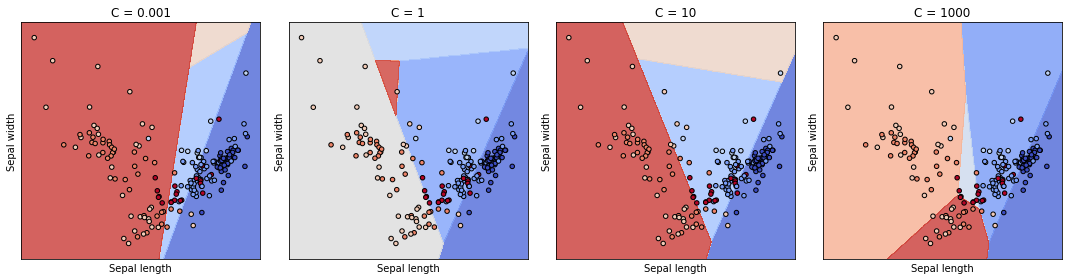

In [19]:
# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(1, 4)
fig.set_size_inches(15, 4)
plt.subplots_adjust(wspace=0.4, hspace=2)

MAX_POINTS = 200

X0, X1 = X[0:MAX_POINTS, 0], X[0:MAX_POINTS, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y[0:MAX_POINTS], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    
save_fig('linearsvc_Cs')

plt.show()

# ovr

In [20]:
# ovr that shit
fulldata = full_pipeline.fit_transform(df)
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

pca = PCA(n_components=2)
pca.fit(fulldata)

fulldata_pca2 = pca.transform(fulldata)

In [21]:
fulldata_labels_ordinal[:,0]

array([0., 0., 0., ..., 0., 1., 0.])

In [22]:
cat_encoder.categories_

[array(['np_freebsd.raw', 'np_nuc.raw', 'np_tohiba.raw', 'np_ubuntu.raw',
        'np_windows10x86.raw', 'np_x58pc.raw'], dtype=object)]

training... Done.
Saving figure linearsvc_Cs_-Lab-D


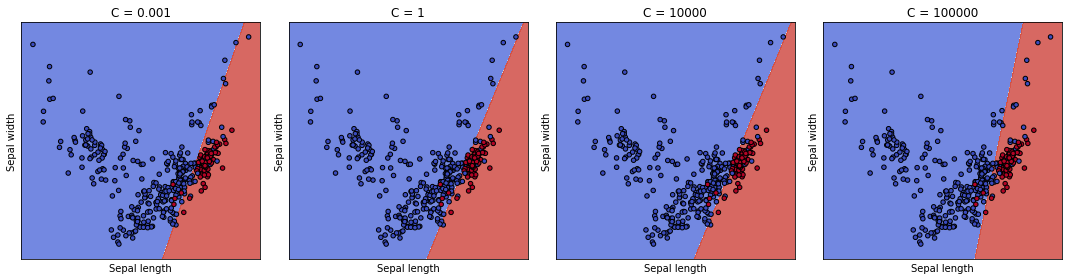

training... Done.
Saving figure linearsvc_Cs_-Lab-A


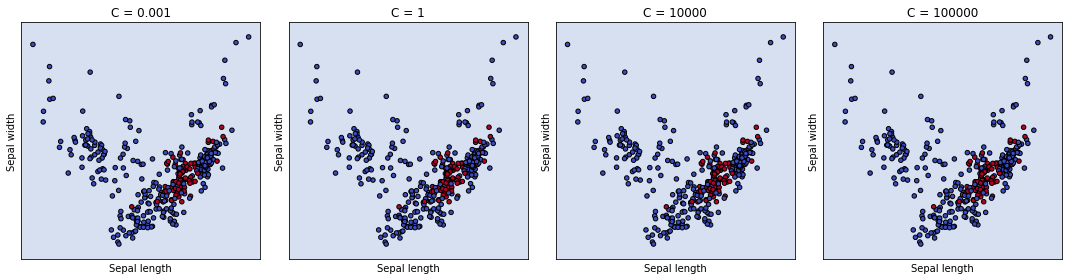

training... Done.
Saving figure linearsvc_Cs_-Lab-C


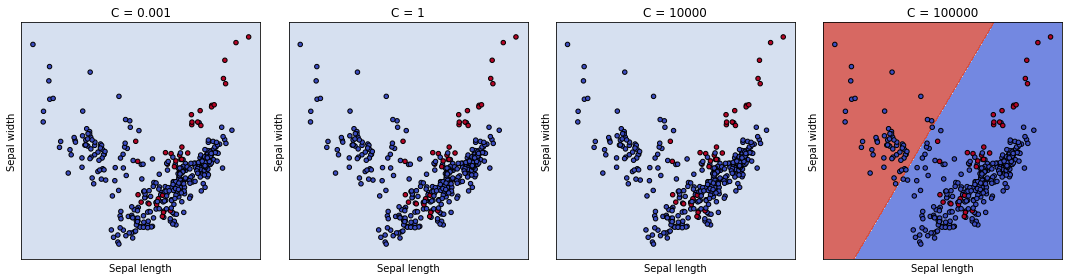

training... Done.
Saving figure linearsvc_Cs_-Lab-1


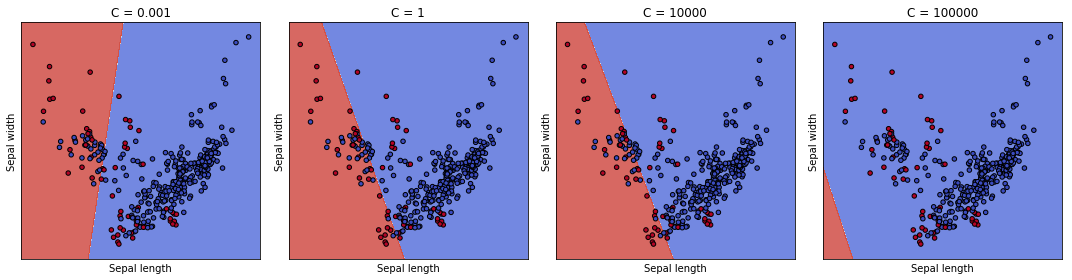

training... Done.
Saving figure linearsvc_Cs_-Lab-B


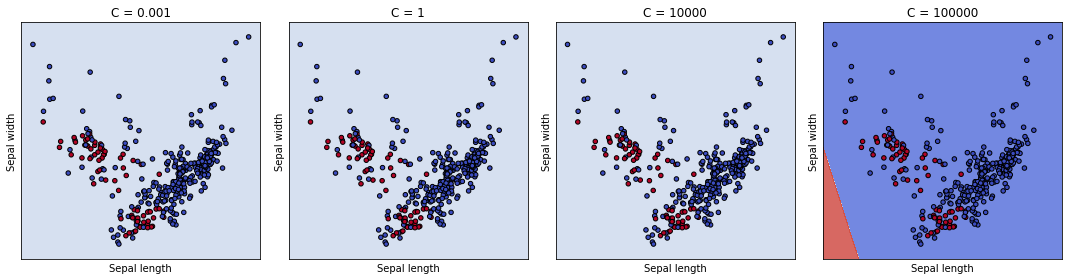

training... Done.


IndexError: list index out of range

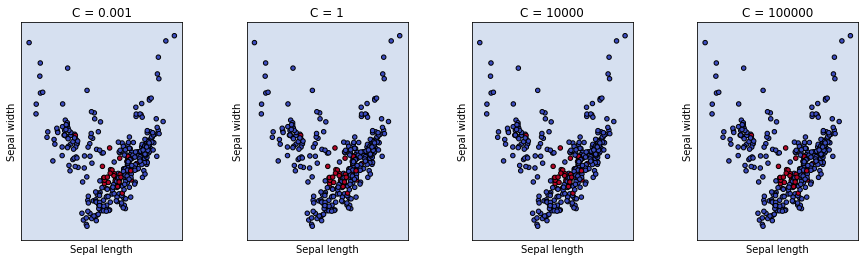

In [23]:
for i in range(0,fulldata_labels_ordinal.shape[1]):
    
    X = fulldata_pca2
    y = fulldata_labels_ordinal[:,i]

    # we create an instance of SVM and fit out data. We do not scale our
    # data since we want to plot the support vectors

    models = (svm.LinearSVC(C=0.001, loss='hinge',max_iter=5000),
              svm.LinearSVC(C=1, loss='hinge',max_iter=5000),
              svm.LinearSVC(C=10, loss='hinge',max_iter=5000),
              svm.LinearSVC(C=1000, loss='hinge',max_iter=5000)
             )

    print("training...", end=" ")
    models = (clf.fit(X, y) for clf in models)
    print("Done.")



    # title for the plots
    titles = ('C = 0.001',
              'C = 1',
              'C = 10000',
              'C = 100000'
             )
    
    graphs = ['Lab-D', 'Lab-A', 'Lab-C', 'Lab-1','Lab-B']
    
#Lab-1                  & Provides a baseline for Ubuntu OS fingerprint  \\ #ubunut
#Lab-A                  & Multi-purpose machine and server               \\ # nuc
#Lab-B                  & Desktop computer                               \\ # x58
#Lab-C                  & Laptop Computer                                \\ # toshiba
#Lab-D                  & FREEBSD   
    
    
#[array(['np_freebsd.raw', 'np_nuc.raw', 'np_tohiba.raw', 'np_ubuntu.raw','np_x58pc.raw'], dtype=object)]
    
    # Set-up 2x2 grid for plotting.
    fig, sub = plt.subplots(1, 4)
    fig.set_size_inches(15, 4)
    
    plt.subplots_adjust(wspace=0.4, hspace=2)

    MAX_POINTS = 400

    X0, X1 = X[0:MAX_POINTS, 0], X[0:MAX_POINTS, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y[0:MAX_POINTS], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('Sepal length')
        ax.set_ylabel('Sepal width')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

    save_fig(f'linearsvc_Cs_-{graphs[i]}')

    plt.show()
    

# C gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

#http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html

fulldata = full_pipeline.fit_transform(df)
cat_encoder = CategoricalEncoder(encoding="ordinal")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

pipe = Pipeline([
    #('reduce_dim', PCA()),
    #('reduce_dim', None,),
    ('classify', None)
])

param_grid= [
    {
        #'reduce_dim': [PCA()],
        #'reduce_dim__n_components': [2, 3, 5, 7, 37, 41, 43, 47, 53, 59, 73, 79, 83,],
        #'reduce_dim__n_components': [73, 83,],
        'classify': [svm.LinearSVC(loss='hinge',max_iter=5000)],
        'classify__C': [0.1, 1, 1000, 10000, 100000],
    },
]


# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_c = GridSearchCV(pipe, cv=5,
                           #scoring='neg_mean_squared_error',
                           scoring='accuracy',
                           return_train_score=True,
                           n_jobs=6,
                           param_grid=param_grid,
                           verbose=True)
grid_search_c.fit(fulldata,
                    fulldata_labels_ordinal.ravel())

In [ ]:
cvres = grid_search_c.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres["params"]):
    print(mean_score, params)

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

pd_res = pd.DataFrame(grid_search_c.cv_results_)
pd_res = pd_res.sort_values(by=['rank_test_score'])
pd_res

In [ ]:
for i in range(0,pd_res.shape[0]):
    print(f"Rank:{pd_res['rank_test_score'][i]} Score:{pd_res['mean_test_score'][i]} +- {pd_res['std_test_score'][i]} C:{pd_res['param_classify__C'][i]} ")

# C + PCA

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

#http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html

fulldata = full_pipeline.fit_transform(df)
cat_encoder = CategoricalEncoder(encoding="ordinal")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

pipe = Pipeline([
    #('reduce_dim', PCA()),
    ('reduce_dim', None,),
    ('classify', None)
])

param_grid= [
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': [2, 3, 5, 7, 37, 41, 43, 47, 53, 59, 73, 79, 83,],
        #'reduce_dim__n_components': [73, 83,],
        'classify': [svm.LinearSVC(loss='hinge',max_iter=5000)],
        'classify__C': [0.1, 1, 1000, 10000, 100000],
    },
]


# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_c_pca = GridSearchCV(pipe, cv=5,
                           #scoring='neg_mean_squared_error',
                           scoring='accuracy',
                           return_train_score=True,
                           n_jobs=6,
                           param_grid=param_grid,
                           verbose=True)
grid_search_c_pca.fit(fulldata,
                    fulldata_labels_ordinal.ravel())

In [ ]:
pd_res = pd.DataFrame(grid_search_c_pca.cv_results_)
pd_res = pd_res.sort_values(by=['rank_test_score'])
pd_res

In [ ]:
for i in range(0,pd_res.shape[0]):
    print(f"Rank:{pd_res['rank_test_score'][i]} Score:{pd_res['mean_test_score'][i]} +- {pd_res['std_test_score'][i]} C:{pd_res['param_classify__C'][i]} PCA:{pd_res['param_reduce_dim__n_components'][i]}")

# confusion matrix

In [24]:
df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame

#encode window
df['relative_day_position'] = df['relative_day_position'].apply(lambda x: int((x*24)/285)  )

#remove zeros
df = df[df['packet_count:mean'] != 0]

fulldata = full_pipeline.fit_transform(df)
cat_encoder = CategoricalEncoder(encoding="ordinal")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)



Automatically created module for IPython interactive environment
Normalized confusion matrix
[[9.99e-01 5.60e-04 0.00e+00 0.00e+00 4.48e-04 1.12e-04]
 [1.18e-04 9.41e-01 4.58e-02 1.53e-03 3.88e-03 7.65e-03]
 [2.11e-03 2.45e-02 9.45e-01 7.65e-03 1.29e-02 8.18e-03]
 [0.00e+00 0.00e+00 0.00e+00 9.41e-01 5.92e-02 2.59e-04]
 [1.57e-04 0.00e+00 1.57e-04 5.50e-02 9.45e-01 0.00e+00]
 [3.35e-03 2.34e-03 2.68e-03 1.00e-03 5.36e-03 9.85e-01]]
Saving figure conf_mat
Normalized confusion matrix
[[0.   0.5  0.   0.   0.4  0.1 ]
 [0.   0.   0.78 0.03 0.07 0.13]
 [0.04 0.44 0.   0.14 0.23 0.15]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.99 0.   0.  ]
 [0.23 0.16 0.18 0.07 0.36 0.  ]]
Saving figure conf_mat_errors


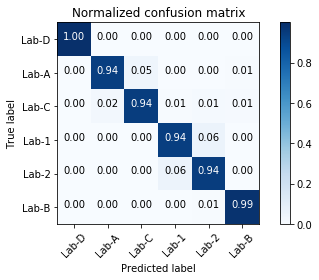

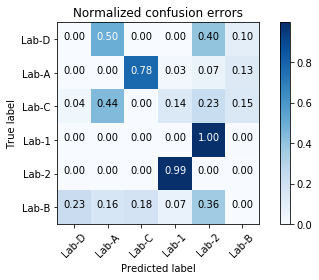

In [26]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

X = fulldata
y = fulldata_labels_ordinal.ravel()



class_names = [labnames[x] for x in list(cat_encoder.categories_[0])]


# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.LinearSVC(loss='hinge',max_iter=5000, C=1)
classifier.fit(X, y)

y_pred = cross_val_predict(classifier, X, y, cv=3)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

save_fig('conf_mat')


plt.figure()

row_sums = cnf_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = cnf_matrix / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plot_confusion_matrix(norm_conf_mx, classes=class_names, normalize=True,
                      title='Normalized confusion errors')

save_fig('conf_mat_errors')

plt.show()

# worst and best scenario

In [220]:
df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame


#filter
#df = df[df.entity != 'np_windows10x86.raw']
#df = df
#df = df[df.entity != 'np_ubuntu.raw']
df = df[df.entity != 'np_x58pc.raw']
df = df[df.entity != 'np_tohiba.raw']
df = df[df.entity != 'np_nuc.raw']
df = df[df.entity != 'np_freebsd.raw']

labnames = {
    'np_freebsd.raw':'Lab-D',
    'np_nuc.raw':'Lab-A',
    'np_tohiba.raw':'Lab-C',
    'np_ubuntu.raw':'Lab-1',
    'np_windows10x86.raw':'Lab-2',
    'np_x58pc.raw':'Lab-B'
}


# lab 1 vs lab 2 # worst
# lab a vs lab c # 2nd worst
# lab 1 vs lab c # best
#giro ['Lab-A', 'Lab-1']

#encode window
df['relative_day_position'] = df['relative_day_position'].apply(lambda x: int((x*24)/285)  )

#remove zeros
df = df[df['packet_count:mean'] != 0]

fulldata = full_pipeline.fit_transform(df)
cat_encoder = CategoricalEncoder(encoding="ordinal")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

pca = PCA(n_components=2)
pca.fit(fulldata)

fulldata_pca2 = pca.transform(fulldata)

[labnames[x] for x in list(cat_encoder.categories_[0])]

['Lab-1', 'Lab-2']

In [228]:
MAX = 2000

datasets = [
    (fulldata_pca2, fulldata_labels_ordinal.ravel())
    #(fulldata_pca2_B[:2000], fulldata_labels_ordinal_B.ravel()[:2000])
]

Automatically created module for IPython interactive environment
1, 2, 2
Saving figure worst_case_C


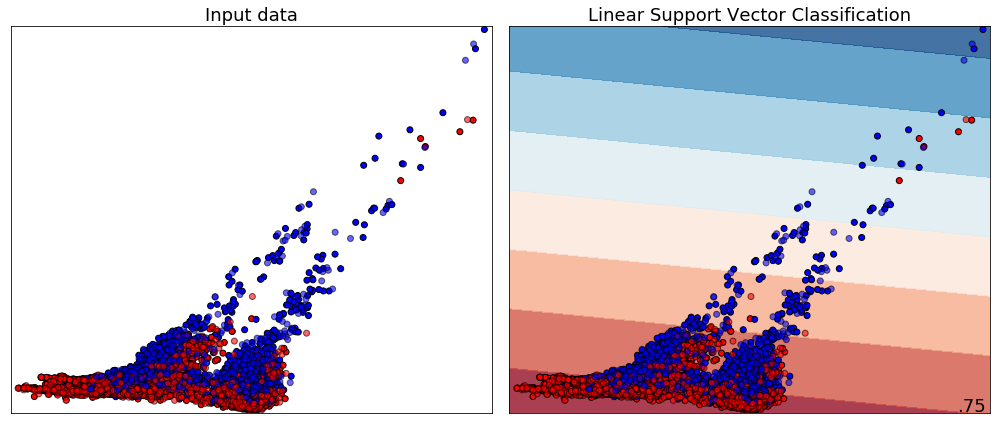

In [232]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names =["Linear Support Vector Classification"]

classifiers = [ svm.LinearSVC(C=1.0, 
                        class_weight=None,
                        dual=True, 
                        fit_intercept=True,
                        intercept_scaling=1,
                        loss='hinge',
                        max_iter=5000,
                        multi_class='ovr',
                        penalty='l2',
                        random_state=None,
                        tol=0.0001,
                        verbose=0)
              ]


#classifiers = [svm.SVC(cache_size=3000, kernel='rbf')]

figure = plt.figure(figsize=(14, 6))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    
    X, y = ds
    
    #X = StandardScaler().fit_transform(X)
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data", size=18)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        print(f"{len(datasets)}, {len(classifiers) + 1}, {i}")
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name,size=18)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=18, horizontalalignment='right')
        i += 1

plt.tight_layout()
save_fig('worst_case_C')
plt.show()

In [ ]:
#3d pca

In [214]:
df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame


#filter
#df = df[df.entity != 'np_windows10x86.raw']
#df = df
#df = df[df.entity != 'np_ubuntu.raw']
df = df[df.entity != 'np_x58pc.raw']
df = df[df.entity != 'np_tohiba.raw']
df = df[df.entity != 'np_nuc.raw']
df = df[df.entity != 'np_freebsd.raw']

labnames = {
    'np_freebsd.raw':'Lab-D',
    'np_nuc.raw':'Lab-A',
    'np_tohiba.raw':'Lab-C',
    'np_ubuntu.raw':'Lab-1',
    'np_windows10x86.raw':'Lab-2',
    'np_x58pc.raw':'Lab-B'
}


# lab 1 vs lab 2 # worst
# lab a vs lab c # 2nd worst
# lab 1 vs lab c # best
#giro ['Lab-A', 'Lab-1']

#encode window
df['relative_day_position'] = df['relative_day_position'].apply(lambda x: int((x*24)/285)  )

#remove zeros
df = df[df['packet_count:mean'] != 0]

fulldata = full_pipeline.fit_transform(df)
cat_encoder = CategoricalEncoder(encoding="ordinal")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

[labnames[x] for x in list(cat_encoder.categories_[0])]

['Lab-1', 'Lab-2']

In [215]:
MAX = 2000

datasets = [
    (fulldata_pca2, fulldata_labels_ordinal.ravel())
    #(fulldata_pca2_B[:2000], fulldata_labels_ordinal_B.ravel()[:2000])
]

Automatically created module for IPython interactive environment
Saving figure worst_case_C_3D


/home/luminoso/thesis/venv/lib64/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


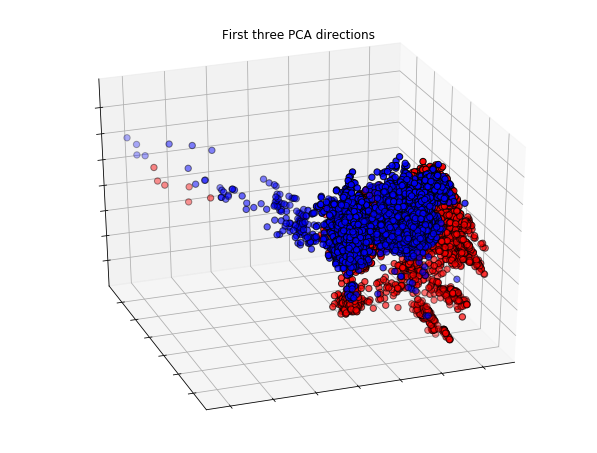

In [219]:
print(__doc__)


# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

X = fulldata_pca2
y = fulldata_labels_ordinal.ravel()


x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

#plt.figure(2, figsize=(8, 6))
#plt.clf()
#
## Plot the training points
#plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,
#            edgecolor='k')
#plt.xlabel('Sepal length')
#plt.ylabel('Sepal width')
#
#plt.xlim(x_min, x_max)
#plt.ylim(y_min, y_max)
#plt.xticks(())
#plt.yticks(())

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(fulldata)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=cm_bright, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("")
ax.w_zaxis.set_ticklabels([])

save_fig('worst_case_C_3D')

plt.show()

# features significance 

In [158]:

features_group1_descriptions = ['packet_count',
                        'ip_external',
                        'ip_internal',
                        'port_high',
                        'port_low',
                        'tcp_syn',
                        'tcp_fin',
                        'tcp_rst',
                        'volume_down',
                        'volume_up',
                        'volume_internal',
                        'less_64kb']

features_group1__combinations = ['mean', 'skew', 'kurtosis', 'var']



group1 = []
for d in features_group1_descriptions:
    for f in features_group1__combinations:
        group1.append(f"{d}:{f}")

        
group2 = []

group2.append('count_nonzero')
group2.append('relative_day_position')
#group2.append('is_weekday')
group2.append('silent_occr')
group2.append('silent_mean')
group2.append('silent_var')

group3 = []
for i in range(0,10):
    group3.append(f"wavelet_{i}")
    
groups = [group1, group2, group3, group1+group2, group1+group3, group2+group3]



In [159]:
df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame

#encode window
df['relative_day_position'] = df['relative_day_position'].apply(lambda x: int((x*24)/285)  )

#remove zeros
df = df[df['packet_count:mean'] != 0]

df_original = df.copy()

In [160]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
for i,group in enumerate(groups):
    df = df_original.copy()
    df = df.drop(columns=group)
    
    num_attribs = list(df.drop("entity", axis=1))  # numerical attributes

    # numerical and categorical pipelines
    num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

    sliding_window_pipeline = Pipeline([
        ('selector', DataFrameSelector('relative_day_position')),
        ('revel',DataFrameRevel()),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

    from sklearn.pipeline import FeatureUnion

    full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("sliding_window_pipeline", sliding_window_pipeline),
    ])

    full_pipeline_no_day = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        #("sliding_window_pipeline", sliding_window_pipeline),
    ])
    
    print(df.shape, end=" ")
    print(i)
    print(df.columns)
    
    if 'relative_day_position' in df.columns:
        fulldata = full_pipeline.fit_transform(df)
    else:
        fulldata = full_pipeline_no_day.fit_transform(df)
    
    cat_encoder = CategoricalEncoder(encoding="ordinal")
    fulldata_labels = df['entity'].values.reshape(-1, 1)
    fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)
    

    svm_clf = svm.LinearSVC(C=1.0, 
                            class_weight=None,
                            dual=True, 
                            fit_intercept=True,
                            intercept_scaling=1,
                            loss='hinge',
                            max_iter=5000,
                            multi_class='ovr',
                            penalty='l2',
                            random_state=None,
                            tol=0.0001,
                            verbose=0)


    scores = cross_val_score(svm_clf,
                             fulldata,
                             fulldata_labels_ordinal.ravel()
                             #scoring='accuracy'
                            )
    
    print("Accuracy: %0.2f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    print(" ")
    

(38295, 16) 0
Index(['entity', 'count_nonzero', 'relative_day_position', 'silent_occr',
       'silent_mean', 'silent_var', 'wavelet_0', 'wavelet_1', 'wavelet_2',
       'wavelet_3', 'wavelet_4', 'wavelet_5', 'wavelet_6', 'wavelet_7',
       'wavelet_8', 'wavelet_9'],
      dtype='object')
Accuracy: 0.67 (+/- 0.0209)
 
(38295, 59) 1
Index(['entity', 'packet_count:mean', 'packet_count:skew',
       'packet_count:kurtosis', 'packet_count:var', 'ip_external:mean',
       'ip_external:skew', 'ip_external:kurtosis', 'ip_external:var',
       'ip_internal:mean', 'ip_internal:skew', 'ip_internal:kurtosis',
       'ip_internal:var', 'port_high:mean', 'port_high:skew',
       'port_high:kurtosis', 'port_high:var', 'port_low:mean', 'port_low:skew',
       'port_low:kurtosis', 'port_low:var', 'tcp_syn:mean', 'tcp_syn:skew',
       'tcp_syn:kurtosis', 'tcp_syn:var', 'tcp_fin:mean', 'tcp_fin:skew',
       'tcp_fin:kurtosis', 'tcp_fin:var', 'tcp_rst:mean', 'tcp_rst:skew',
       'tcp_rst:kurtosis', 

In [ ]:
# remove....
#(38295, 16) 0 Accuracy: 0.67 (+/- 0.0209) #redes
#(38295, 59) 1 Accuracy: 0.96 (+/- 0.0215) #silencios
#(38295, 54) 2 Accuracy: 0.96 (+/- 0.0312) #wavelets
#(38295, 11) 3 Accuracy: 0.39 (+/- 0.0322) #só wavelets
#(38295, 6) 4 Accuracy: 0.51 (+/- 0.0981)  #só silencios
#(38295, 49) 5 Accuracy: 0.96 (+/- 0.0179) #só rede

In [164]:
features_group1_descriptions = ['packet_count',
                        'ip_external',
                        'ip_internal',
                        'port_high',
                        'port_low',
                        'tcp_syn',
                        'tcp_fin',
                        'tcp_rst',
                        'volume_down',
                        'volume_up',
                        'volume_internal',
                        'less_64kb']

features_group1__combinations = ['mean', 'skew', 'kurtosis', 'var']



group1_a = []
for d in features_group1_descriptions:
    for f in ['mean', ]:
        group1_a.append(f"{d}:{f}")
        
        
group1_b = []
for d in features_group1_descriptions:
    for f in [ 'skew',]:
        group1_b.append(f"{d}:{f}")

group1_c = []
for d in features_group1_descriptions:
    for f in [ 'kurtosis',]:
        group1_c.append(f"{d}:{f}")
        
group1_d = []
for d in features_group1_descriptions:
    for f in [ 'var']:
        group1_d.append(f"{d}:{f}")

        
group2 = []

group2.append('count_nonzero')
group2.append('relative_day_position')
#group2.append('is_weekday')
group2.append('silent_occr')
group2.append('silent_mean')
group2.append('silent_var')

group3 = []
for i in range(0,10):
    group3.append(f"wavelet_{i}")
    
groups = [group1_a, group1_b, group1_c, group1_d]



In [165]:
df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame

#encode window
df['relative_day_position'] = df['relative_day_position'].apply(lambda x: int((x*24)/285)  )

#remove zeros
df = df[df['packet_count:mean'] != 0]

df_original = df.copy()

In [166]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
for i,group in enumerate(groups):
    df = df_original.copy()
    df = df.drop(columns=group)
    
    num_attribs = list(df.drop("entity", axis=1))  # numerical attributes

    # numerical and categorical pipelines
    num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

    sliding_window_pipeline = Pipeline([
        ('selector', DataFrameSelector('relative_day_position')),
        ('revel',DataFrameRevel()),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

    from sklearn.pipeline import FeatureUnion

    full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("sliding_window_pipeline", sliding_window_pipeline),
    ])

    full_pipeline_no_day = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        #("sliding_window_pipeline", sliding_window_pipeline),
    ])
    
    print(df.shape, end=" ")
    print(i)
    print(df.columns)
    
    if 'relative_day_position' in df.columns:
        fulldata = full_pipeline.fit_transform(df)
    else:
        fulldata = full_pipeline_no_day.fit_transform(df)
    
    cat_encoder = CategoricalEncoder(encoding="ordinal")
    fulldata_labels = df['entity'].values.reshape(-1, 1)
    fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)
    

    svm_clf = svm.LinearSVC(C=1.0, 
                            class_weight=None,
                            dual=True, 
                            fit_intercept=True,
                            intercept_scaling=1,
                            loss='hinge',
                            max_iter=5000,
                            multi_class='ovr',
                            penalty='l2',
                            random_state=None,
                            tol=0.0001,
                            verbose=0)


    scores = cross_val_score(svm_clf,
                             fulldata,
                             fulldata_labels_ordinal.ravel()
                             #scoring='accuracy'
                            )
    
    print("Accuracy: %0.2f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    print(" ")
    

(38295, 52) 0
Index(['entity', 'packet_count:skew', 'packet_count:kurtosis',
       'packet_count:var', 'ip_external:skew', 'ip_external:kurtosis',
       'ip_external:var', 'ip_internal:skew', 'ip_internal:kurtosis',
       'ip_internal:var', 'port_high:skew', 'port_high:kurtosis',
       'port_high:var', 'port_low:skew', 'port_low:kurtosis', 'port_low:var',
       'tcp_syn:skew', 'tcp_syn:kurtosis', 'tcp_syn:var', 'tcp_fin:skew',
       'tcp_fin:kurtosis', 'tcp_fin:var', 'tcp_rst:skew', 'tcp_rst:kurtosis',
       'tcp_rst:var', 'volume_down:skew', 'volume_down:kurtosis',
       'volume_down:var', 'volume_up:skew', 'volume_up:kurtosis',
       'volume_up:var', 'volume_internal:skew', 'volume_internal:kurtosis',
       'volume_internal:var', 'less_64kb:skew', 'less_64kb:kurtosis',
       'less_64kb:var', 'count_nonzero', 'relative_day_position',
       'silent_occr', 'silent_mean', 'silent_var', 'wavelet_0', 'wavelet_1',
       'wavelet_2', 'wavelet_3', 'wavelet_4', 'wavelet_5', 'wavel

# PCA right number of dimensions

In [198]:
df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame


#encode window
df['relative_day_position'] = df['relative_day_position'].apply(lambda x: int((x*24)/285)  )

#remove zeros
df = df[df['packet_count:mean'] != 0]

fulldata = full_pipeline.fit_transform(df)
cat_encoder = CategoricalEncoder(encoding="ordinal")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)


In [200]:
pca = PCA()
pca.fit(fulldata)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [201]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [202]:
d

32

Text(0,0.5,'cumulative explained variance')

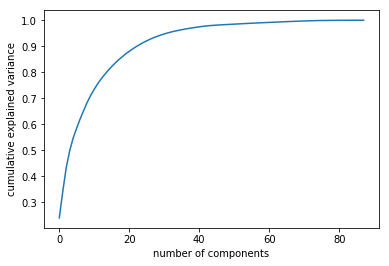

In [203]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Saving figure pca_variance_095


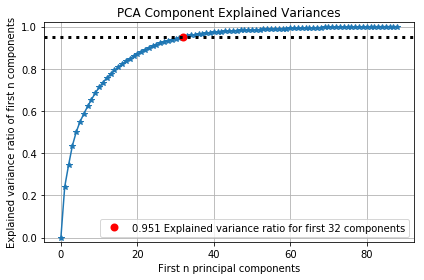

In [206]:
import scikitplot as skplt
skplt.decomposition.plot_pca_component_variance(pca,target_explained_variance=0.95)
save_fig('pca_variance_095')
plt.show()


In [207]:
pca.explained_variance_ratio_

array([2.41e-01, 1.02e-01, 9.22e-02, 6.49e-02, 4.93e-02, 3.74e-02,
       3.55e-02, 3.22e-02, 3.09e-02, 2.67e-02, 2.31e-02, 2.13e-02,
       1.90e-02, 1.66e-02, 1.57e-02, 1.46e-02, 1.36e-02, 1.26e-02,
       1.12e-02, 1.11e-02, 9.85e-03, 9.29e-03, 8.70e-03, 8.16e-03,
       7.42e-03, 6.67e-03, 6.49e-03, 5.81e-03, 4.99e-03, 4.71e-03,
       4.38e-03, 3.99e-03, 3.67e-03, 3.10e-03, 2.85e-03, 2.71e-03,
       2.53e-03, 2.30e-03, 2.25e-03, 2.04e-03, 1.90e-03, 1.82e-03,
       1.51e-03, 1.39e-03, 1.00e-03, 8.96e-04, 8.33e-04, 7.42e-04,
       7.40e-04, 7.34e-04, 7.29e-04, 7.26e-04, 7.17e-04, 7.07e-04,
       6.92e-04, 6.69e-04, 6.49e-04, 6.38e-04, 6.29e-04, 6.21e-04,
       6.04e-04, 5.95e-04, 5.87e-04, 5.85e-04, 5.73e-04, 5.63e-04,
       5.60e-04, 5.54e-04, 5.25e-04, 5.04e-04, 4.70e-04, 4.55e-04,
       3.81e-04, 3.65e-04, 3.10e-04, 2.30e-04, 2.14e-04, 1.80e-04,
       1.41e-04, 1.25e-04, 9.83e-05, 8.76e-05, 7.04e-05, 6.63e-05,
       5.86e-05, 3.99e-06, 1.03e-33, 8.44e-34])

In [208]:
pca = PCA(n_components=0.95)
pca.fit(fulldata)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [209]:
svm_clf = svm.LinearSVC(C=1.0, 
                            class_weight=None,
                            dual=True, 
                            fit_intercept=True,
                            intercept_scaling=1,
                            loss='hinge',
                            max_iter=5000,
                            multi_class='ovr',
                            penalty='l2',
                            random_state=None,
                            tol=0.0001,
                            verbose=0)


scores = cross_val_score(svm_clf,
                             fulldata,
                             fulldata_labels_ordinal.ravel()
                             #scoring='accuracy'
                            )
    
print("Accuracy: %0.2f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.96 (+/- 0.0296)


In [235]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(kernel='rbf')
X_reduced = rbf_pca.fit(fulldata)

In [ ]:
skplt.decomposition.plot_pca_component_variance(pca,target_explained_variance=0.95)
#save_fig('pca_variance_095')
plt.show()


# abnormality detection

In [14]:
# Load serialized dataframe

import pickle
import pandas as pd

# [86400, 21600, 7200, 3600, 900]

file = "df_900_0.3_v3.raw"

df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame

#encode window
df['relative_day_position'] = df['relative_day_position'].apply(lambda x: int((x*24)/285)  )

#remove zeros
df = df[df['packet_count:mean'] != 0]

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

num_attribs = list(df.drop("entity", axis=1))  # numerical attributes

# numerical and categorical pipelines
num_pipeline = Pipeline([
    #('imputer', Imputer(strategy="median")),
    #('attribs_adder', CombinedAttributesAdder()),
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
    #('robust_scaler', RobustScaler()),
])

sliding_window_pipeline = Pipeline([
    ('selector', DataFrameSelector('relative_day_position')),
    ('revel',DataFrameRevel()),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("sliding_window_pipeline", sliding_window_pipeline),
])

fulldata = full_pipeline.fit_transform(df)

fulldata = full_pipeline.fit_transform(df)
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

In [241]:
algos =[ 
         (svm.SVC(),'svm svc'), # C-Support Vector Classification.
         (svm.LinearSVC(), 'svm_linear'), # Linear Support Vector Classification.
         #(svm.NuSVC(), 'nusvc'), # Nu-Support Vector Classification.
         #(svm.NuSVR(), 'nusvr'), # Nu Support Vector Regression.
         #(svm.SVR(),'svr'), # Epsilon-Support Vector Regression.
         #(DecisionTreeClassifier(),'dtree'), # Decision Tree Classifier
         #(DecisionTreeRegressor(),'dtreerg'), # Decision Trees Regressor
         #(KNeighborsClassifier(n_neighbors=3),'near'), # K-nearest neighbors
         (MLPClassifier(solver='adam', # Multi-layer Perceptron classifier
                           alpha=1e-5,
                           hidden_layer_sizes=(5, 2),
                           #random_state=1,
                           max_iter=10000,
                           learning_rate='adaptive'),'neural'),
        #(KNeighborsClassifier(3),'knei_3'),
        #(GaussianProcessClassifier(1.0 * RBF(1.0)),'gaussian'),
        #(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),'randomforest'), # Random Forest Classifier
        (AdaBoostClassifier(),'adaboost'), # AdaBoost Classifier
        #(GaussianNB(),'gaussianNB'), # Gaussian Naive Bayes (GaussianNB)
        #(QuadraticDiscriminantAnalysis(),'quadratic') # Quadratic Discriminant Analysis
]

for i in range(0,fulldata_labels_ordinal.shape[1]):
    print(df_categories[i])                   
    for al in algos:
        classifier, name = al
    
        scores = cross_val_score(classifier,
                             fulldata,
                             fulldata_labels_ordinal[:,i].ravel()
                             #scoring='accuracy'
                            )

        print("Accuracy %s: %0.2f (+/- %0.4f)" % (name, scores.mean(), scores.std() * 2))
    print("")

np_ubuntu.raw
Accuracy svm svc: 1.00 (+/- 0.0002)
Accuracy svm_linear: 0.98 (+/- 0.0656)
Accuracy neural: 0.91 (+/- 0.2427)
Accuracy adaboost: 1.00 (+/- 0.0005)

np_nuc.raw
Accuracy svm svc: 0.95 (+/- 0.0709)
Accuracy svm_linear: 0.93 (+/- 0.0550)
Accuracy neural: 0.91 (+/- 0.0852)
Accuracy adaboost: 0.95 (+/- 0.0414)

np_windows10x86.raw
Accuracy svm svc: 0.76 (+/- 0.5153)
Accuracy svm_linear: 0.77 (+/- 0.5245)
Accuracy neural: 0.76 (+/- 0.5265)
Accuracy adaboost: 0.82 (+/- 0.4334)

np_x58pc.raw
Accuracy svm svc: 0.84 (+/- 0.3950)
Accuracy svm_linear: 0.84 (+/- 0.3764)
Accuracy neural: 0.79 (+/- 0.3591)
Accuracy adaboost: 0.84 (+/- 0.4391)

np_freebsd.raw
Accuracy svm svc: 0.86 (+/- 0.3392)
Accuracy svm_linear: 0.86 (+/- 0.2862)
Accuracy neural: 0.87 (+/- 0.3201)
Accuracy adaboost: 0.88 (+/- 0.3098)

np_tohiba.raw
Accuracy svm svc: 0.99 (+/- 0.0028)
Accuracy svm_linear: 0.98 (+/- 0.0416)
Accuracy neural: 0.96 (+/- 0.0819)
Accuracy adaboost: 1.00 (+/- 0.0003)



In [ ]:
# Confusion matrix binarized

In [5]:
# Load serialized dataframe

import pickle
import pandas as pd

# [86400, 21600, 7200, 3600, 900]

file = "df_900_0.3_v3.raw"

df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame

#encode window
df['relative_day_position'] = df['relative_day_position'].apply(lambda x: int((x*24)/285)  )

#remove zeros
df = df[df['packet_count:mean'] != 0]

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

num_attribs = list(df.drop("entity", axis=1))  # numerical attributes

# numerical and categorical pipelines
num_pipeline = Pipeline([
    #('imputer', Imputer(strategy="median")),
    #('attribs_adder', CombinedAttributesAdder()),
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
    #('robust_scaler', RobustScaler()),
])

sliding_window_pipeline = Pipeline([
    ('selector', DataFrameSelector('relative_day_position')),
    ('revel',DataFrameRevel()),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("sliding_window_pipeline", sliding_window_pipeline),
])

fulldata = full_pipeline.fit_transform(df)

fulldata = full_pipeline.fit_transform(df)
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)


In [6]:
cat_encoder.categories_

[array(['np_freebsd.raw', 'np_nuc.raw', 'np_tohiba.raw', 'np_ubuntu.raw',
        'np_windows10x86.raw', 'np_x58pc.raw'], dtype=object)]

In [7]:
type(fulldata_labels_ordinal)

numpy.ndarray

In [8]:
fulldata_labels_ordinal[:,3]

array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict


svm_clf = svm.LinearSVC(C=1.0, 
                        class_weight=None,
                        dual=True, 
                        fit_intercept=True,
                        intercept_scaling=1,
                        loss='hinge',
                        max_iter=5000,
                        multi_class='ovr',
                        penalty='l2',
                        random_state=None,
                        tol=0.0001,
                        verbose=0)

train_pred = cross_val_predict(svm_clf, fulldata, fulldata_labels_ordinal[:,3].ravel(), cv=3)


In [13]:
confusion_matrix(fulldata_labels_ordinal[:,3].ravel(), train_pred)

array([[24698,  5871],
       [  494,  7232]])

In [14]:
tn, fp, fn, tp = confusion_matrix(fulldata_labels_ordinal[:,3].ravel(), train_pred).ravel()
(tn, fp, fn, tp)

(24698, 5871, 494, 7232)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

#http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

pipe = Pipeline([
    #('reduce_dim', PCA()),
    ('reduce_dim', None,),
    ('classify', svm.LinearSVC())
])

param_grid= [
    {
        'reduce_dim': [PCA()],
        #'reduce_dim__n_components': [2, 3, 5, 7, 37, 41, 43, 47, 53, 59, 73, 79, 83,],
        'reduce_dim__n_components': [47, 59, 73, 83,],
        'classify': [svm.LinearSVC(loss='hinge')],
        'classify__C': [0.1, 1, 10, 1000],
    },
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': [47, 59, 79,],
        'classify': [svm.SVC(cache_size=3000)],
        'classify__kernel': ['poly','rbf'],
        'classify__gamma': [0.1, 1, 5, 10],
        'classify__C': [0.1, 1, 10, 1000],
    },
]


# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(pipe, cv=5,
                           #scoring='neg_mean_squared_error',
                           scoring='accuracy',
                           return_train_score=True,
                           n_jobs=6,
                           param_grid=param_grid,
                           verbose=True)
grid_search.fit(fulldata,
                fulldata_labels_ordinal.ravel())

In [ ]:
grid_search.best_params_

In [ ]:
cvres = grid_search.cv_results_
cvres.keys()


In [ ]:
for mean_score, params in zip(cvres['mean_test_score'], cvres["params"]):
    print(mean_score, params)

In [ ]:
cvres = grid_search.cv_results_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres["params"]):
    print(f"{np.sqrt(mean_score)}\t PCA:{params['reduce_dim__n_components']} \t C:{params['classify__C']}")

In [ ]:
cvres["params"][0]['reduce_dim__n_components']

In [ ]:
cvres["params"][0]['reduce_dim__n_components']

In [ ]:
pd_res = pd.DataFrame(grid_search.cv_results_)

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd_res.sort_values(by=['mean_test_score'])

In [ ]:
#fulldata = full_pipeline.fit_transform(df)
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
fulldata_labels_oneH = onehot_encoder.fit_transform(df_encoded.reshape(-1, 1))

In [ ]:
fulldata_labels_oneH

In [ ]:
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

algos =[ (svm.SVC(),'svm svc'), # C-Support Vector Classification.
         (svm.LinearSVC(), 'svm_linear'), # Linear Support Vector Classification.
         #(svm.NuSVC(), 'nusvc'), # Nu-Support Vector Classification.
         #(svm.NuSVR(), 'nusvr'), # Nu Support Vector Regression.
         (svm.SVR(),'svr'), # Epsilon-Support Vector Regression.
         (DecisionTreeClassifier(),'dtree'), # Decision Tree Classifier
         (DecisionTreeRegressor(),'dtreerg'), # Decision Trees Regressor
         (KNeighborsClassifier(n_neighbors=3),'near'), # K-nearest neighbors
         (MLPClassifier(solver='adam', # Multi-layer Perceptron classifier
                           alpha=1e-5,
                           hidden_layer_sizes=(5, 2),
                           #random_state=1,
                           max_iter=10000,
                           learning_rate='adaptive'),'neural'),
        (KNeighborsClassifier(3),'knei_3'),
        #(GaussianProcessClassifier(1.0 * RBF(1.0)),'gaussian'),
        (RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),'randomforest'), # Random Forest Classifier
        (AdaBoostClassifier(),'adaboost'), # AdaBoost Classifier
        (GaussianNB(),'gaussianNB'), # Gaussian Naive Bayes (GaussianNB)
        (QuadraticDiscriminantAnalysis(),'quadratic') # Quadratic Discriminant Analysis
]

for i in range(0,fulldata_labels_oneH.shape[1]):
    print(df_categories[i])                   
    for al in algos:
        classifier, name = al
    
        scores = cross_val_score(classifier,
                             fulldata,
                             fulldata_labels_oneH[:,i].toarray().ravel()
                             #scoring='accuracy'
                            )

        print("Accuracy %s: %0.2f (+/- %0.4f)" % (name, scores.mean(), scores.std() * 2 * 100))
    print("")

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

#http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', DecisionTreeClassifier())
])

dec_t_grid = [
    {'criterion':['gini','entropy'],
     'splitter':['best','random'],
     'max_depth': [1,10,100,1000,None],
     'min_samples_split': [2,20,200,2000],
     'max_features': [1,10,15,25,40,'sqrt','log2',None],
     'presort': [False,True]
    }
]

param_grid= [
    {
        'reduce_dim': [PCA()],
        #'reduce_dim__n_components': [2,5,10,25,35,40],
        'reduce_dim__n_components': [25,35,40,45,55,60],
        'classify__criterion':['gini'],#,'entropy'],
        'classify__splitter':['best','random'],
        #'classify__max_depth': [10,100,None],
        #'classify__min_samples_split': [2,10,],
        #'classify__max_features': ['auto','sqrt','log2',None],
        #'classify__presort': [False,True]
    }
]


dt_clas = DecisionTreeClassifier()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(pipe, cv=5,
                           #scoring='neg_mean_squared_error', 
                           return_train_score=True,
                           n_jobs=4,
                           param_grid=param_grid,
                          verbose=True)
grid_search.fit(fulldata,
                fulldata_labels_ordinal.ravel())

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f"{mean_score} {params}")

In [ ]:
dt_clas = DecisionTreeClassifier()
dt_clas.fit(fulldata,
                fulldata_labels_ordinal.ravel(),
           
           )


#'classify__max_features': [1,10,15,25,40,'sqrt','log2',None]

# decision/recall/etc


In [13]:
# Load serialized dataframe

import pickle
import pandas as pd

# [86400, 21600, 7200, 3600, 900]

file = "df_900_0.3_v3.raw"

df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame

#encode window
df['relative_day_position'] = df['relative_day_position'].apply(lambda x: int((x*24)/285)  )

#remove zeros
df = df[df['packet_count:mean'] != 0]

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

num_attribs = list(df.drop("entity", axis=1))  # numerical attributes

# numerical and categorical pipelines
num_pipeline = Pipeline([
    #('imputer', Imputer(strategy="median")),
    #('attribs_adder', CombinedAttributesAdder()),
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
    #('robust_scaler', RobustScaler()),
])

sliding_window_pipeline = Pipeline([
    ('selector', DataFrameSelector('relative_day_position')),
    ('revel',DataFrameRevel()),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("sliding_window_pipeline", sliding_window_pipeline),
])

fulldata = full_pipeline.fit_transform(df)

fulldata = full_pipeline.fit_transform(df)
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

In [14]:
cat_encoder.categories_

[array(['np_freebsd.raw', 'np_nuc.raw', 'np_tohiba.raw', 'np_ubuntu.raw',
        'np_windows10x86.raw', 'np_x58pc.raw'], dtype=object)]

In [15]:
#fulldata
#fulldata_labels_oneH[:,i].toarray().ravel()

In [16]:
from sklearn import svm
svm_clas = svm.LinearSVC()
#svm_clas.fit(fulldata, fulldata_labels_ordinal[:,4].ravel(), )


LAB = 4 # win10

#LAB = 0 # freebsd

In [17]:
from sklearn.model_selection import cross_val_predict
scores = cross_val_predict(svm_clas, fulldata, 
                fulldata_labels_ordinal[:,LAB].ravel(),
                cv=5)


In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(fulldata_labels_ordinal[:,LAB].ravel(), scores)



Saving figure precision_vs_recall_plot_lab2


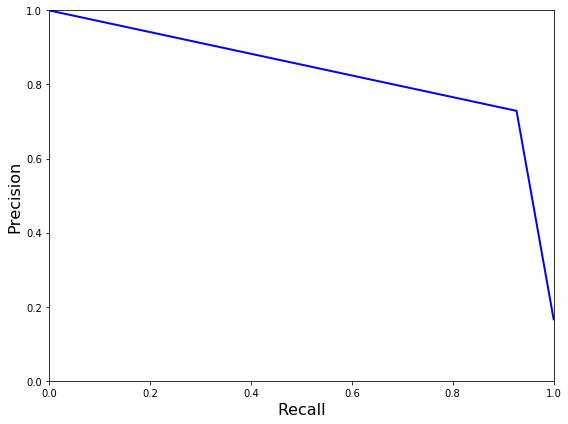

In [126]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot_lab2")
plt.show()

In [127]:
precisions

array([0.1660269, 0.72878  , 1.       ])

Saving figure precision_recall_curve_lab2


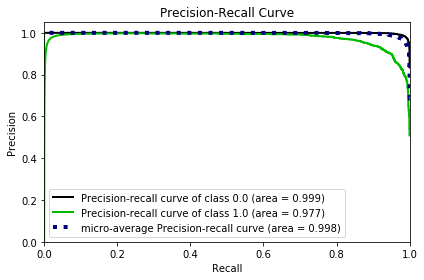

In [33]:
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

X_train, X_test, y_train, y_test = train_test_split(fulldata,fulldata_labels_ordinal[:,LAB].ravel(), 
                                                    test_size=0.33, random_state=42)

nb = svm.LinearSVC()
clf = CalibratedClassifierCV(nb)


clf.fit(X_train, y_train)

y_probas = clf.predict_proba(X_test)
ax = skplt.metrics.plot_precision_recall_curve(y_test, y_probas)

#ax.set_xlim(left=0.60, right=1.0)

save_fig('precision_recall_curve_lab2')


#ax.show()

In [141]:
np.unique(y_test)

array([0., 1.])

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

X_train = fulldata
y_train_5 = fulldata_labels_ordinal[:,4].ravel()
sgd_clf = dt_clas

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9765784114052953
0.9553466509988249
0.6627232842369163


In [25]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [26]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.5550239234449761

In [27]:
recall_score(y_train_5, y_train_pred)

0.93048128342246

In [28]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.6953046953046953

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [30]:
y_scores.shape

(38295,)

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


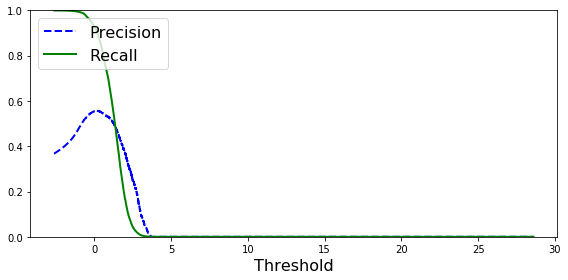

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Saving figure precision_vs_recall_plot


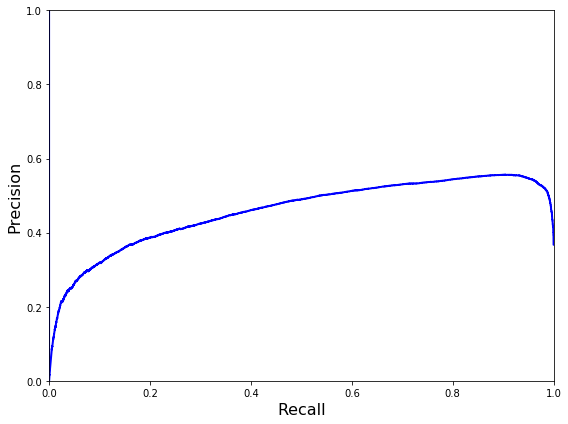

In [37]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot_lab2")
plt.show()

In [84]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


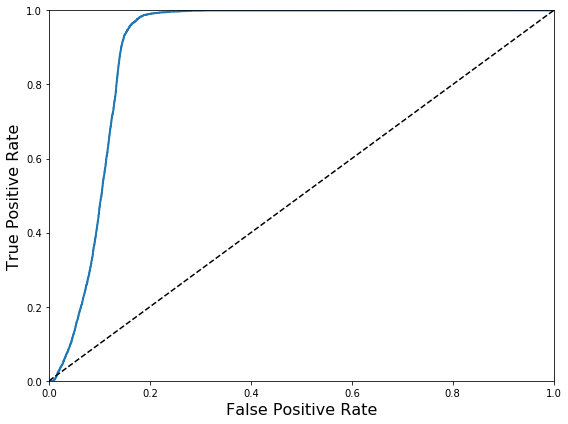

In [88]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9001104801690472

In [41]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

knei = KNeighborsClassifier()
y_probas_knei = cross_val_predict(knei, X_train, y_train_5, cv=3,
                                    method="predict_proba")

NameError: name 'KNeighborsClassifier' is not defined

In [42]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [43]:
y_scores_knei = y_probas_knei[:, 1] # score = proba of positive class
fpr_knei, tpr_knei, thresholds_knei = roc_curve(y_train_5,y_scores_knei)

NameError: name 'y_probas_knei' is not defined

NameError: name 'fpr_knei' is not defined

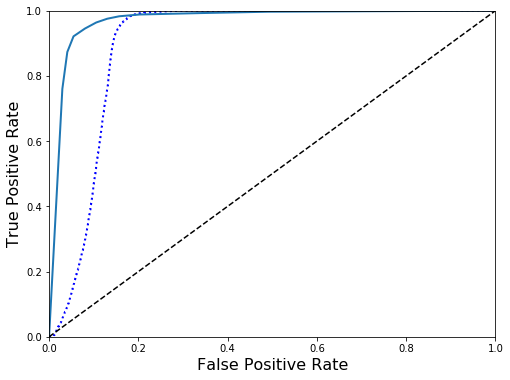

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_knei, tpr_knei, "K-nei")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

In [ ]:
recall_score(y_train_5, y_train_pred_forest)